# Data Prep

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [2]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
all_ann

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [3]:
#max image size
height = 50
width = 50
data = []
labels = []
path = "lib/datasets/LISA/"
test = 0
for i in range(len(all_ann["Filename"])):
    file = all_ann["Filename"][i]
    sign = all_ann["Annotation tag"][i]
    image = Image.open(path+file)
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)


signs = np.array(data)
labels = np.array(labels)

# Randomize order
s = np.arange(signs.shape[0])
np.random.seed(43)
np.random.shuffle(s)
signs = signs[s]
labels = labels[s]

In [13]:
def one_hot(lab, vals):
    hot = []
    for i in range(len(vals)):
        # tmp = np.zeros(len(lab))
        # tmp[np.where(lab == i)] = 1
        hot.append(lab.tolist().index(vals[i]))
        # hot[i] = np.where(lab == vals[i])
        # hot.append(tmp)
    return hot

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(signs, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Preprocess
X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
X_test = X_test.astype('float64')

# Normalize
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



In [15]:
# Encode
lab = np.unique(labels)
from tensorflow.keras.utils import to_categorical
y_train_e = to_categorical(one_hot(lab,y_train),47)
y_test_e = to_categorical(one_hot(lab,y_test),47)
y_val_e = to_categorical(one_hot(lab,y_val),47)

### Modeling

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [23]:
model=Sequential()
#adding convolution layer
model.add(Conv2D(32,(5,5),activation='relu',input_shape=X_train.shape[1:]))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(47,activation='softmax'))
#compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
epochs = 20
history = model.fit(X_train, y_train_e, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val_e))

Epoch 1/20
148/148 [==============================] - 2s 10ms/step - loss: 5.1184 - accuracy: 0.1859 - val_loss: 2.7530 - val_accuracy: 0.2775
Epoch 2/20
148/148 [==============================] - 1s 8ms/step - loss: 2.6005 - accuracy: 0.2864 - val_loss: 2.1630 - val_accuracy: 0.4360
Epoch 3/20
148/148 [==============================] - 1s 8ms/step - loss: 2.0355 - accuracy: 0.4210 - val_loss: 1.6479 - val_accuracy: 0.5773
Epoch 4/20
148/148 [==============================] - 1s 8ms/step - loss: 1.6110 - accuracy: 0.5309 - val_loss: 1.1958 - val_accuracy: 0.6773
Epoch 5/20
148/148 [==============================] - 1s 8ms/step - loss: 1.2786 - accuracy: 0.6230 - val_loss: 0.8699 - val_accuracy: 0.7530
Epoch 6/20
148/148 [==============================] - 1s 8ms/step - loss: 1.0480 - accuracy: 0.6870 - val_loss: 0.6953 - val_accuracy: 0.7995
Epoch 7/20
148/148 [==============================] - 1s 8ms/step - loss: 0.9033 - accuracy: 0.7210 - val_loss: 0.6856 - val_accuracy: 0.8052
Epoch

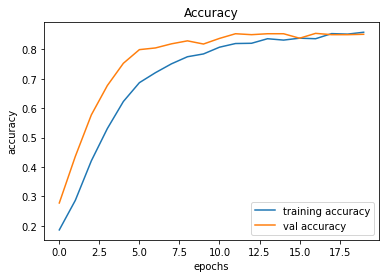

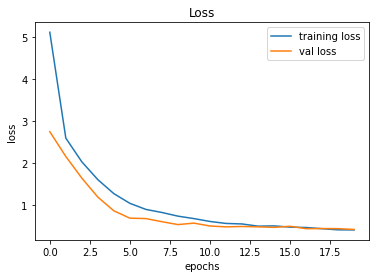

In [24]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()